## Backtest portfolio from Black-litterman model for asset allocation

In [1]:
import sys
sys.path.append('/usr/local/lib/python3.7/site-packages')
sys.path.append('/Users/li/Library/Python/3.7/lib/python/site-packages')
sys.path.append('/usr/local/lib/python3.7/site-packages/PyPortfolioOpt-1.2.5-py3.7.egg')
sys.path.append('/usr/local/lib/python3.7/site-packages/backtrader-1.9.76.123-py3.7.egg')

In [2]:
import os
import datetime
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import pandas_datareader.data as web
from datetime import datetime

import yfinance as yf
import pyfolio as pf
import pypfopt as pyp
import backtrader as bt

/usr/local/lib/python3.7/site-packages/pyfolio/pos.py:27: UserWarning: Module "zipline.assets" not found; mutltipliers will not be applied to position notionals.
  'Module "zipline.assets" not found; mutltipliers will not be applied' +


### 1. Load data and visualize

In [6]:
import imp
import model
imp.reload(model)
from model import build_data


data_dir = '../data/NSE'
prices, market_prices, mcap, views_dict, confidences = build_data(data_dir=data_dir)

prices_all = pd.read_csv(
    os.path.join(data_dir, 'prices_all.csv'), 
    index_col=['ticker', 'date'], 
    parse_dates=True
) # stock price all

benchmark = '^BSESN' # Benchmark price
benchmark_prices = web.DataReader(benchmark, 'yahoo', start='2010-01-01')['Adj Close']
benchmark_prices = benchmark_prices.asfreq('D', method='ffill')
benchmark_prices = benchmark_prices.filter(prices.index)
benchmark_prices.index = benchmark_prices.index.tz_localize('UTC')

[*********************100%***********************]  1 of 1 completed


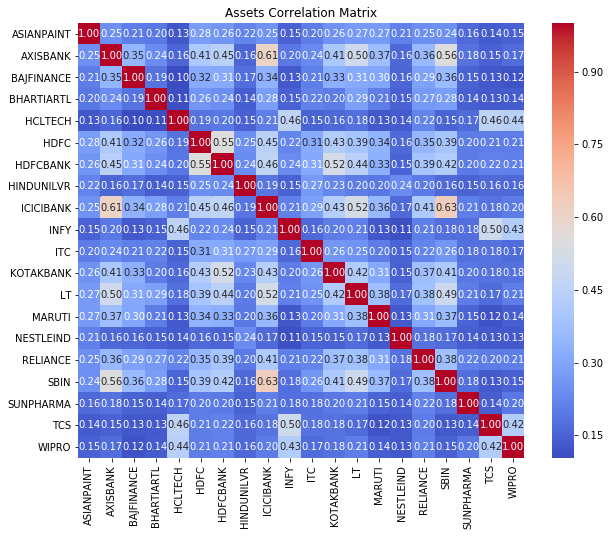

In [107]:
# Plot
fig, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(prices.pct_change().corr(method='spearman'), ax=ax, cmap='coolwarm', annot=True, fmt=".2f")
ax.set_title('Assets Correlation Matrix')
plt.show()

### 2. Portfolio optimization

In [8]:
import imp
import model
imp.reload(model)
from model import bl_optimize, plot_performance

end_date = datetime(2015, 4, 1)
weight_bounds=(0, 0.1)
omega = None

returns_df, weights_df = bl_optimize(
    prices,
    market_prices,
    mcap,
    views_dict,
    end_date=end_date,
    years_before_enddate=3,
    omega=omega,
    confidences=confidences,
    weight_bounds=weight_bounds,
    return_df=True,  # whether to return dataframe
    save_dir='data',
    visualize=False
)

Compute weights from 2012-04-02 00:00:00 to 2015-04-01 00:00:00


### 3. Backtest simple strategy

In [157]:
# Backtest
import imp
import strategy
imp.reload(strategy)
from strategy import SimpleWeightsStrategy

startcash = 500000
commission = 0.004
start_date = datetime(2010, 1, 1)
end_date = datetime(2020, 5, 29)

cerebro = bt.Cerebro()
cerebro.broker.setcash(startcash)
cerebro.broker.setcommission(commission=commission)
cerebro.broker.set_checksubmit(False)

for ticker, data in prices_all.groupby(level=0):
    data = bt.feeds.PandasData(dataname=data.droplevel(level=0),
                               name=str(ticker),
                               fromdate=start_date,
                               todate=end_date,
                               plot=False)
    cerebro.adddata(data)


asset_weights = list(zip(weights_df.index, weights_df['weights']))
equal_asset_weights = [(i[0], float(1/len(asset_weights)*100)) for i in asset_weights]
cerebro.addstrategy(SimpleWeightsStrategy, assets=equal_asset_weights)

cerebro.addanalyzer(bt.analyzers.Returns, _name='returns')
cerebro.addanalyzer(bt.analyzers.TimeReturn, _name='time_return')
cerebro.addanalyzer(bt.analyzers.PyFolio, _name='pyfolio')

In [158]:
results = cerebro.run(stdstats=True, tradehistory=False)
print('Final Portfolio Value:', cerebro.broker.getvalue())

2010-01-04 00:00:00 Sending Order: ASIANPAINT | Month 1 | Rebalanced: False | Pos: 0
2010-01-04 00:00:00 Sending Order: AXISBANK | Month 1 | Rebalanced: False | Pos: 0
2010-01-04 00:00:00 Sending Order: BAJFINANCE | Month 1 | Rebalanced: False | Pos: 0
2010-01-04 00:00:00 Sending Order: BHARTIARTL | Month 1 | Rebalanced: False | Pos: 0
2010-01-04 00:00:00 Sending Order: HCLTECH | Month 1 | Rebalanced: False | Pos: 0
2010-01-04 00:00:00 Sending Order: HDFC | Month 1 | Rebalanced: False | Pos: 0
2010-01-04 00:00:00 Sending Order: HDFCBANK | Month 1 | Rebalanced: False | Pos: 0
2010-01-04 00:00:00 Sending Order: HINDUNILVR | Month 1 | Rebalanced: False | Pos: 0
2010-01-04 00:00:00 Sending Order: ICICIBANK | Month 1 | Rebalanced: False | Pos: 0
2010-01-04 00:00:00 Sending Order: INFY | Month 1 | Rebalanced: False | Pos: 0
2010-01-04 00:00:00 Sending Order: ITC | Month 1 | Rebalanced: False | Pos: 0
2010-01-04 00:00:00 Sending Order: KOTAKBANK | Month 1 | Rebalanced: False | Pos: 0
2010-01-

2010-09-01 00:00:00 Sending Order: ASIANPAINT | Month 9 | Rebalanced: False | Pos: 136
2010-09-01 00:00:00 Sending Order: AXISBANK | Month 9 | Rebalanced: False | Pos: 101
2010-09-01 00:00:00 Sending Order: BAJFINANCE | Month 9 | Rebalanced: False | Pos: 811
2010-09-01 00:00:00 Sending Order: BHARTIARTL | Month 9 | Rebalanced: False | Pos: 79
2010-09-01 00:00:00 Sending Order: HCLTECH | Month 9 | Rebalanced: False | Pos: 290
2010-09-01 00:00:00 Sending Order: HDFC | Month 9 | Rebalanced: False | Pos: 33
2010-09-01 00:00:00 Sending Order: HDFCBANK | Month 9 | Rebalanced: False | Pos: 122
2010-09-01 00:00:00 Sending Order: HINDUNILVR | Month 9 | Rebalanced: False | Pos: 90
2010-09-01 00:00:00 Sending Order: ICICIBANK | Month 9 | Rebalanced: False | Pos: 218
2010-09-01 00:00:00 Sending Order: INFY | Month 9 | Rebalanced: False | Pos: 127
2010-09-01 00:00:00 Sending Order: ITC | Month 9 | Rebalanced: False | Pos: 245
2010-09-01 00:00:00 Sending Order: KOTAKBANK | Month 9 | Rebalanced: Fals

2011-06-01 00:00:00 Sending Order: ASIANPAINT | Month 6 | Rebalanced: False | Pos: 129
2011-06-01 00:00:00 Sending Order: AXISBANK | Month 6 | Rebalanced: False | Pos: 120
2011-06-01 00:00:00 Sending Order: BAJFINANCE | Month 6 | Rebalanced: False | Pos: 701
2011-06-01 00:00:00 Sending Order: BHARTIARTL | Month 6 | Rebalanced: False | Pos: 78
2011-06-01 00:00:00 Sending Order: HCLTECH | Month 6 | Rebalanced: False | Pos: 283
2011-06-01 00:00:00 Sending Order: HDFC | Month 6 | Rebalanced: False | Pos: 35
2011-06-01 00:00:00 Sending Order: HDFCBANK | Month 6 | Rebalanced: False | Pos: 128
2011-06-01 00:00:00 Sending Order: HINDUNILVR | Month 6 | Rebalanced: False | Pos: 93
2011-06-01 00:00:00 Sending Order: ICICIBANK | Month 6 | Rebalanced: False | Pos: 213
2011-06-01 00:00:00 Sending Order: INFY | Month 6 | Rebalanced: False | Pos: 137
2011-06-01 00:00:00 Sending Order: ITC | Month 6 | Rebalanced: False | Pos: 247
2011-06-01 00:00:00 Sending Order: KOTAKBANK | Month 6 | Rebalanced: Fals

2012-03-01 00:00:00 Sending Order: ASIANPAINT | Month 3 | Rebalanced: False | Pos: 95
2012-03-01 00:00:00 Sending Order: AXISBANK | Month 3 | Rebalanced: False | Pos: 137
2012-03-01 00:00:00 Sending Order: BAJFINANCE | Month 3 | Rebalanced: False | Pos: 569
2012-03-01 00:00:00 Sending Order: BHARTIARTL | Month 3 | Rebalanced: False | Pos: 73
2012-03-01 00:00:00 Sending Order: HCLTECH | Month 3 | Rebalanced: False | Pos: 310
2012-03-01 00:00:00 Sending Order: HDFC | Month 3 | Rebalanced: False | Pos: 34
2012-03-01 00:00:00 Sending Order: HDFCBANK | Month 3 | Rebalanced: False | Pos: 114
2012-03-01 00:00:00 Sending Order: HINDUNILVR | Month 3 | Rebalanced: False | Pos: 63
2012-03-01 00:00:00 Sending Order: ICICIBANK | Month 3 | Rebalanced: False | Pos: 278
2012-03-01 00:00:00 Sending Order: INFY | Month 3 | Rebalanced: False | Pos: 130
2012-03-01 00:00:00 Sending Order: ITC | Month 3 | Rebalanced: False | Pos: 201
2012-03-01 00:00:00 Sending Order: KOTAKBANK | Month 3 | Rebalanced: False

2013-01-01 00:00:00 Sending Order: ASIANPAINT | Month 1 | Rebalanced: False | Pos: 89
2013-01-01 00:00:00 Sending Order: AXISBANK | Month 1 | Rebalanced: False | Pos: 167
2013-01-01 00:00:00 Sending Order: BAJFINANCE | Month 1 | Rebalanced: False | Pos: 362
2013-01-01 00:00:00 Sending Order: BHARTIARTL | Month 1 | Rebalanced: False | Pos: 129
2013-01-01 00:00:00 Sending Order: HCLTECH | Month 1 | Rebalanced: False | Pos: 270
2013-01-01 00:00:00 Sending Order: HDFC | Month 1 | Rebalanced: False | Pos: 39
2013-01-01 00:00:00 Sending Order: HDFCBANK | Month 1 | Rebalanced: False | Pos: 104
2013-01-01 00:00:00 Sending Order: HINDUNILVR | Month 1 | Rebalanced: False | Pos: 62
2013-01-01 00:00:00 Sending Order: ICICIBANK | Month 1 | Rebalanced: False | Pos: 244
2013-01-01 00:00:00 Sending Order: INFY | Month 1 | Rebalanced: False | Pos: 181
2013-01-01 00:00:00 Sending Order: ITC | Month 1 | Rebalanced: False | Pos: 185
2013-01-01 00:00:00 Sending Order: KOTAKBANK | Month 1 | Rebalanced: Fals

2013-09-02 00:00:00 Sending Order: ASIANPAINT | Month 9 | Rebalanced: False | Pos: 86
2013-09-02 00:00:00 Sending Order: AXISBANK | Month 9 | Rebalanced: False | Pos: 145
2013-09-02 00:00:00 Sending Order: BAJFINANCE | Month 9 | Rebalanced: False | Pos: 317
2013-09-02 00:00:00 Sending Order: BHARTIARTL | Month 9 | Rebalanced: False | Pos: 133
2013-09-02 00:00:00 Sending Order: HCLTECH | Month 9 | Rebalanced: False | Pos: 244
2013-09-02 00:00:00 Sending Order: HDFC | Month 9 | Rebalanced: False | Pos: 41
2013-09-02 00:00:00 Sending Order: HDFCBANK | Month 9 | Rebalanced: False | Pos: 113
2013-09-02 00:00:00 Sending Order: HINDUNILVR | Month 9 | Rebalanced: False | Pos: 68
2013-09-02 00:00:00 Sending Order: ICICIBANK | Month 9 | Rebalanced: False | Pos: 222
2013-09-02 00:00:00 Sending Order: INFY | Month 9 | Rebalanced: False | Pos: 187
2013-09-02 00:00:00 Sending Order: ITC | Month 9 | Rebalanced: False | Pos: 183
2013-09-02 00:00:00 Sending Order: KOTAKBANK | Month 9 | Rebalanced: Fals

2014-06-02 00:00:00 Sending Order: ASIANPAINT | Month 6 | Rebalanced: False | Pos: 86
2014-06-02 00:00:00 Sending Order: AXISBANK | Month 6 | Rebalanced: False | Pos: 175
2014-06-02 00:00:00 Sending Order: BAJFINANCE | Month 6 | Rebalanced: False | Pos: 300
2014-06-02 00:00:00 Sending Order: BHARTIARTL | Month 6 | Rebalanced: False | Pos: 139
2014-06-02 00:00:00 Sending Order: HCLTECH | Month 6 | Rebalanced: False | Pos: 132
2014-06-02 00:00:00 Sending Order: HDFC | Month 6 | Rebalanced: False | Pos: 50
2014-06-02 00:00:00 Sending Order: HDFCBANK | Month 6 | Rebalanced: False | Pos: 131
2014-06-02 00:00:00 Sending Order: HINDUNILVR | Month 6 | Rebalanced: False | Pos: 82
2014-06-02 00:00:00 Sending Order: ICICIBANK | Month 6 | Rebalanced: False | Pos: 280
2014-06-02 00:00:00 Sending Order: INFY | Month 6 | Rebalanced: False | Pos: 135
2014-06-02 00:00:00 Sending Order: ITC | Month 6 | Rebalanced: False | Pos: 213
2014-06-02 00:00:00 Sending Order: KOTAKBANK | Month 6 | Rebalanced: Fals

2015-03-02 00:00:00 Sending Order: ASIANPAINT | Month 3 | Rebalanced: False | Pos: 87
2015-03-02 00:00:00 Sending Order: AXISBANK | Month 3 | Rebalanced: False | Pos: 128
2015-03-02 00:00:00 Sending Order: BAJFINANCE | Month 3 | Rebalanced: False | Pos: 193
2015-03-02 00:00:00 Sending Order: BHARTIARTL | Month 3 | Rebalanced: False | Pos: 193
2015-03-02 00:00:00 Sending Order: HCLTECH | Month 3 | Rebalanced: False | Pos: 184
2015-03-02 00:00:00 Sending Order: HDFC | Month 3 | Rebalanced: False | Pos: 55
2015-03-02 00:00:00 Sending Order: HDFCBANK | Month 3 | Rebalanced: False | Pos: 138
2015-03-02 00:00:00 Sending Order: HINDUNILVR | Month 3 | Rebalanced: False | Pos: 88
2015-03-02 00:00:00 Sending Order: ICICIBANK | Month 3 | Rebalanced: False | Pos: 211
2015-03-02 00:00:00 Sending Order: INFY | Month 3 | Rebalanced: False | Pos: 166
2015-03-02 00:00:00 Sending Order: ITC | Month 3 | Rebalanced: False | Pos: 284
2015-03-02 00:00:00 Sending Order: KOTAKBANK | Month 3 | Rebalanced: Fals

2016-01-01 00:00:00 Sending Order: ASIANPAINT | Month 1 | Rebalanced: False | Pos: 83
2016-01-01 00:00:00 Sending Order: AXISBANK | Month 1 | Rebalanced: False | Pos: 111
2016-01-01 00:00:00 Sending Order: BAJFINANCE | Month 1 | Rebalanced: False | Pos: 139
2016-01-01 00:00:00 Sending Order: BHARTIARTL | Month 1 | Rebalanced: False | Pos: 211
2016-01-01 00:00:00 Sending Order: HCLTECH | Month 1 | Rebalanced: False | Pos: 158
2016-01-01 00:00:00 Sending Order: HDFC | Month 1 | Rebalanced: False | Pos: 56
2016-01-01 00:00:00 Sending Order: HDFCBANK | Month 1 | Rebalanced: False | Pos: 136
2016-01-01 00:00:00 Sending Order: HINDUNILVR | Month 1 | Rebalanced: False | Pos: 82
2016-01-01 00:00:00 Sending Order: ICICIBANK | Month 1 | Rebalanced: False | Pos: 280
2016-01-01 00:00:00 Sending Order: INFY | Month 1 | Rebalanced: False | Pos: 144
2016-01-01 00:00:00 Sending Order: ITC | Month 1 | Rebalanced: False | Pos: 336
2016-01-01 00:00:00 Sending Order: KOTAKBANK | Month 1 | Rebalanced: Fals

2016-09-01 00:00:00 Sending Order: ASIANPAINT | Month 9 | Rebalanced: False | Pos: 71
2016-09-01 00:00:00 Sending Order: AXISBANK | Month 9 | Rebalanced: False | Pos: 140
2016-09-01 00:00:00 Sending Order: BAJFINANCE | Month 9 | Rebalanced: False | Pos: 94
2016-09-01 00:00:00 Sending Order: BHARTIARTL | Month 9 | Rebalanced: False | Pos: 215
2016-09-01 00:00:00 Sending Order: HCLTECH | Month 9 | Rebalanced: False | Pos: 207
2016-09-01 00:00:00 Sending Order: HDFC | Month 9 | Rebalanced: False | Pos: 57
2016-09-01 00:00:00 Sending Order: HDFCBANK | Month 9 | Rebalanced: False | Pos: 124
2016-09-01 00:00:00 Sending Order: HINDUNILVR | Month 9 | Rebalanced: False | Pos: 86
2016-09-01 00:00:00 Sending Order: ICICIBANK | Month 9 | Rebalanced: False | Pos: 341
2016-09-01 00:00:00 Sending Order: INFY | Month 9 | Rebalanced: False | Pos: 131
2016-09-01 00:00:00 Sending Order: ITC | Month 9 | Rebalanced: False | Pos: 307
2016-09-01 00:00:00 Sending Order: KOTAKBANK | Month 9 | Rebalanced: False

2017-06-01 00:00:00 Sending Order: ASIANPAINT | Month 6 | Rebalanced: False | Pos: 77
2017-06-01 00:00:00 Sending Order: AXISBANK | Month 6 | Rebalanced: False | Pos: 152
2017-06-01 00:00:00 Sending Order: BAJFINANCE | Month 6 | Rebalanced: False | Pos: 72
2017-06-01 00:00:00 Sending Order: BHARTIARTL | Month 6 | Rebalanced: False | Pos: 239
2017-06-01 00:00:00 Sending Order: HCLTECH | Month 6 | Rebalanced: False | Pos: 189
2017-06-01 00:00:00 Sending Order: HDFC | Month 6 | Rebalanced: False | Pos: 56
2017-06-01 00:00:00 Sending Order: HDFCBANK | Month 6 | Rebalanced: False | Pos: 115
2017-06-01 00:00:00 Sending Order: HINDUNILVR | Month 6 | Rebalanced: False | Pos: 92
2017-06-01 00:00:00 Sending Order: ICICIBANK | Month 6 | Rebalanced: False | Pos: 318
2017-06-01 00:00:00 Sending Order: INFY | Month 6 | Rebalanced: False | Pos: 170
2017-06-01 00:00:00 Sending Order: ITC | Month 6 | Rebalanced: False | Pos: 305
2017-06-01 00:00:00 Sending Order: KOTAKBANK | Month 6 | Rebalanced: False

2018-06-01 00:00:00 Sending Order: ASIANPAINT | Month 6 | Rebalanced: False | Pos: 87
2018-06-01 00:00:00 Sending Order: AXISBANK | Month 6 | Rebalanced: False | Pos: 183
2018-06-01 00:00:00 Sending Order: BAJFINANCE | Month 6 | Rebalanced: False | Pos: 58
2018-06-01 00:00:00 Sending Order: BHARTIARTL | Month 6 | Rebalanced: False | Pos: 205
2018-06-01 00:00:00 Sending Order: HCLTECH | Month 6 | Rebalanced: False | Pos: 209
2018-06-01 00:00:00 Sending Order: HDFC | Month 6 | Rebalanced: False | Pos: 54
2018-06-01 00:00:00 Sending Order: HDFCBANK | Month 6 | Rebalanced: False | Pos: 105
2018-06-01 00:00:00 Sending Order: HINDUNILVR | Month 6 | Rebalanced: False | Pos: 74
2018-06-01 00:00:00 Sending Order: ICICIBANK | Month 6 | Rebalanced: False | Pos: 322
2018-06-01 00:00:00 Sending Order: INFY | Month 6 | Rebalanced: False | Pos: 180
2018-06-01 00:00:00 Sending Order: ITC | Month 6 | Rebalanced: False | Pos: 379
2018-06-01 00:00:00 Sending Order: KOTAKBANK | Month 6 | Rebalanced: False

2019-03-01 00:00:00 Sending Order: ASIANPAINT | Month 3 | Rebalanced: False | Pos: 83
2019-03-01 00:00:00 Sending Order: AXISBANK | Month 3 | Rebalanced: False | Pos: 178
2019-03-01 00:00:00 Sending Order: BAJFINANCE | Month 3 | Rebalanced: False | Pos: 43
2019-03-01 00:00:00 Sending Order: BHARTIARTL | Month 3 | Rebalanced: False | Pos: 379
2019-03-01 00:00:00 Sending Order: HCLTECH | Month 3 | Rebalanced: False | Pos: 234
2019-03-01 00:00:00 Sending Order: HDFC | Month 3 | Rebalanced: False | Pos: 56
2019-03-01 00:00:00 Sending Order: HDFCBANK | Month 3 | Rebalanced: False | Pos: 104
2019-03-01 00:00:00 Sending Order: HINDUNILVR | Month 3 | Rebalanced: False | Pos: 63
2019-03-01 00:00:00 Sending Order: ICICIBANK | Month 3 | Rebalanced: False | Pos: 308
2019-03-01 00:00:00 Sending Order: INFY | Month 3 | Rebalanced: False | Pos: 176
2019-03-01 00:00:00 Sending Order: ITC | Month 3 | Rebalanced: False | Pos: 400
2019-03-01 00:00:00 Sending Order: KOTAKBANK | Month 3 | Rebalanced: False

2020-01-01 00:00:00 Sending Order: ASIANPAINT | Month 1 | Rebalanced: False | Pos: 76
2020-01-01 00:00:00 Sending Order: AXISBANK | Month 1 | Rebalanced: False | Pos: 184
2020-01-01 00:00:00 Sending Order: BAJFINANCE | Month 1 | Rebalanced: False | Pos: 37
2020-01-01 00:00:00 Sending Order: BHARTIARTL | Month 1 | Rebalanced: False | Pos: 354
2020-01-01 00:00:00 Sending Order: HCLTECH | Month 1 | Rebalanced: False | Pos: 217
2020-01-01 00:00:00 Sending Order: HDFC | Month 1 | Rebalanced: False | Pos: 57
2020-01-01 00:00:00 Sending Order: HDFCBANK | Month 1 | Rebalanced: False | Pos: 107
2020-01-01 00:00:00 Sending Order: HINDUNILVR | Month 1 | Rebalanced: False | Pos: 65
2020-01-01 00:00:00 Sending Order: ICICIBANK | Month 1 | Rebalanced: False | Pos: 303
2020-01-01 00:00:00 Sending Order: INFY | Month 1 | Rebalanced: False | Pos: 152
2020-01-01 00:00:00 Sending Order: ITC | Month 1 | Rebalanced: False | Pos: 493
2020-01-01 00:00:00 Sending Order: KOTAKBANK | Month 1 | Rebalanced: False

Start date,2010-01-04
End date,2020-05-29
Total months,122
,Backtest
Annual return,15.8%
Cumulative returns,350.4%
Annual volatility,19.0%
Sharpe ratio,0.88
Calmar ratio,0.44
Stability,0.97
Max drawdown,-36.1%


Start date,2010-01-05
End date,2020-05-29
Total months,122
,Backtest
Annual return,6.2%
Cumulative returns,84.7%
Annual volatility,17.4%
Sharpe ratio,0.43
Calmar ratio,0.16
Stability,0.90
Max drawdown,-38.1%


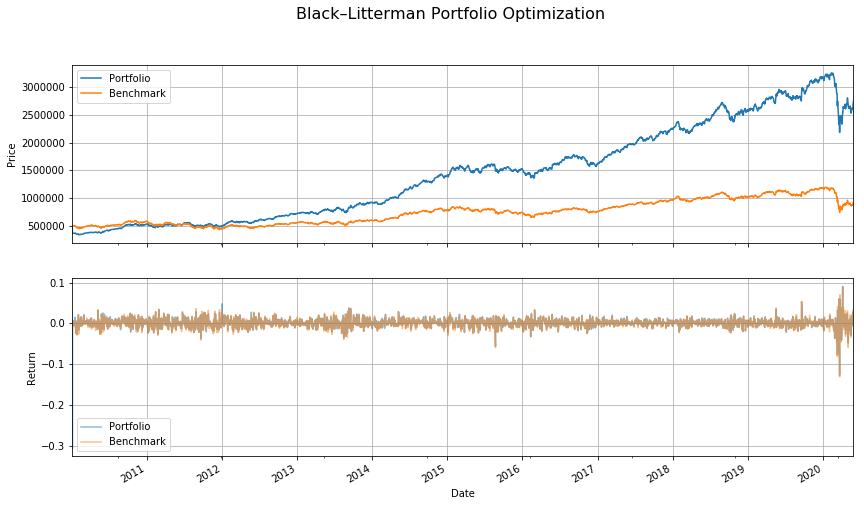

/usr/local/lib/python3.7/site-packages/numpy/core/fromnumeric.py:58: FutureWarning: 
The current behaviour of 'Series.argmin' is deprecated, use 'idxmin'
instead.
The behavior of 'argmin' will be corrected to return the positional
minimum in the future. For now, use 'series.values.argmin' or
'np.argmin(np.array(values))' to get the position of the minimum
row.
  return bound(*args, **kwds)


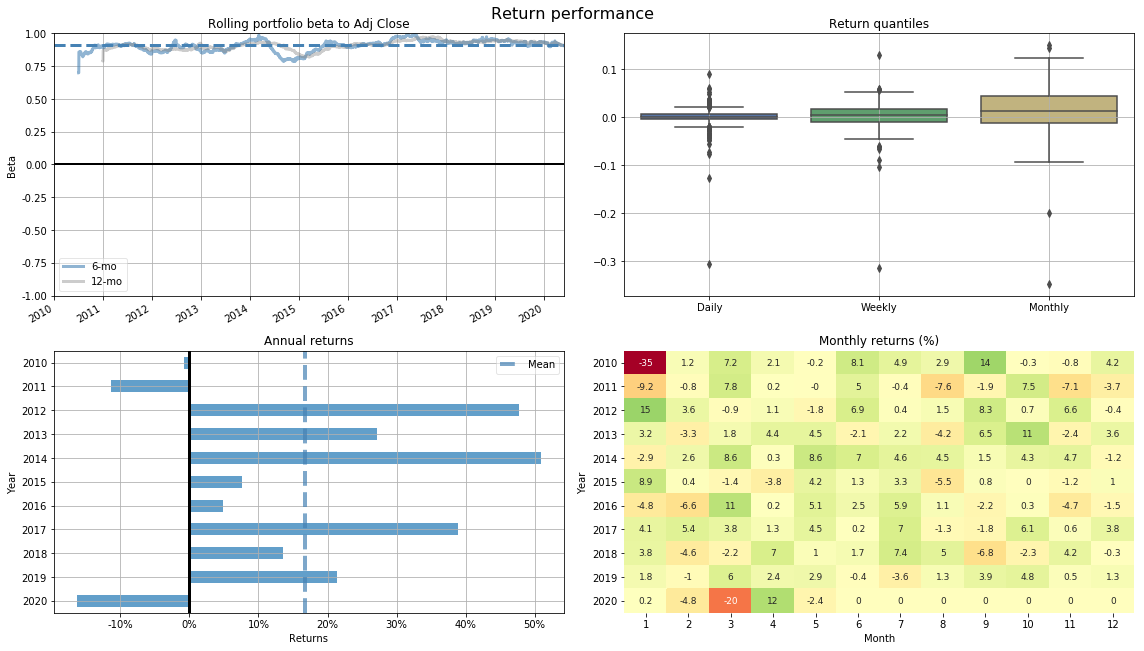

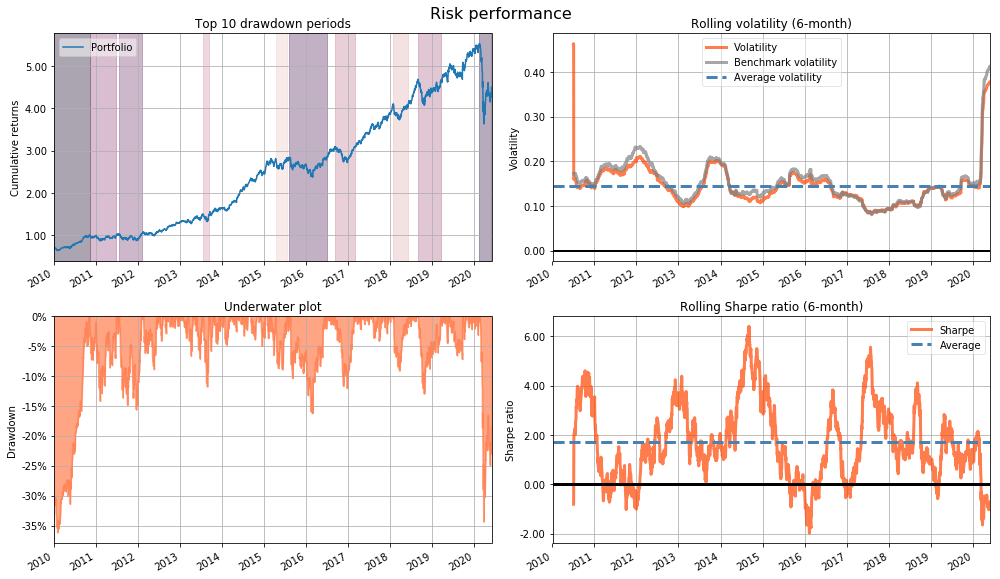

In [139]:
# Plot result
pyfoliozer = results[0].analyzers.getbyname('pyfolio')
returns, positions, transactions, gross_lev = pyfoliozer.get_pf_items()
returns.name = 'Strategy'

plot_performance(
    returns, 
    benchmark_prices, 
    plot_stats=True,
    startcash=startcash,
    log_returns=True,
    save_dir=None
)

### 4. Backtest rolling strategy

In [17]:
# Backtest
import imp
import strategy
imp.reload(strategy)
from strategy import RollingWeightsStrategy

startcash = 500000
commission = 0.004
start_date = datetime(2010, 1, 1)
end_date = datetime(2020, 5, 29)

cerebro = bt.Cerebro()
cerebro.broker.setcash(startcash)
cerebro.broker.setcommission(commission=commission)
cerebro.broker.set_checksubmit(False)

for ticker, data in prices_all.groupby(level=0):
    data = bt.feeds.PandasData(dataname=data.droplevel(level=0),
                               name=str(ticker),
                               fromdate=start_date,
                               todate=end_date,
                               plot=False)
    cerebro.adddata(data)

cerebro.addstrategy(RollingWeightsStrategy)

cerebro.addanalyzer(bt.analyzers.Returns, _name='returns')
cerebro.addanalyzer(bt.analyzers.TimeReturn, _name='time_return')
cerebro.addanalyzer(bt.analyzers.PyFolio, _name='pyfolio')

In [20]:
results = cerebro.run(stdstats=True, tradehistory=False)
print('Final Portfolio Value:', cerebro.broker.getvalue())

[*********************100%***********************]  1 of 1 completed


/Users/li/quant/PyPortfolioOpt/strategies/black_litterman/model.py:94: UserWarning: `prices` should have at least 2 years
  warnings.warn('`prices` must have at least 2 years')


Compute weights from 2010-01-04 00:00:00 to 2012-01-04 00:00:00
2012-01-04 00:00:00 Sending Order: ASIANPAINT | Month 1 | Rebalanced: False | Pos: 0
2012-01-04 00:00:00 Sending Order: AXISBANK | Month 1 | Rebalanced: False | Pos: 0
2012-01-04 00:00:00 Sending Order: BAJFINANCE | Month 1 | Rebalanced: False | Pos: 0
2012-01-04 00:00:00 Sending Order: BHARTIARTL | Month 1 | Rebalanced: False | Pos: 0
2012-01-04 00:00:00 Sending Order: HCLTECH | Month 1 | Rebalanced: False | Pos: 0
2012-01-04 00:00:00 Sending Order: HDFC | Month 1 | Rebalanced: False | Pos: 0
2012-01-04 00:00:00 Sending Order: HDFCBANK | Month 1 | Rebalanced: False | Pos: 0
2012-01-04 00:00:00 Sending Order: HINDUNILVR | Month 1 | Rebalanced: False | Pos: 0
2012-01-04 00:00:00 Sending Order: ICICIBANK | Month 1 | Rebalanced: False | Pos: 0
2012-01-04 00:00:00 Sending Order: INFY | Month 1 | Rebalanced: False | Pos: 0
2012-01-04 00:00:00 Sending Order: ITC | Month 1 | Rebalanced: False | Pos: 0
2012-01-04 00:00:00 Sending 

Compute weights from 2010-01-04 00:00:00 to 2012-09-03 00:00:00
2012-09-03 00:00:00 Sending Order: ASIANPAINT | Month 9 | Rebalanced: False | Pos: 76
2012-09-03 00:00:00 Sending Order: AXISBANK | Month 9 | Rebalanced: False | Pos: 146
2012-09-03 00:00:00 Sending Order: BAJFINANCE | Month 9 | Rebalanced: False | Pos: 413
2012-09-03 00:00:00 Sending Order: BHARTIARTL | Month 9 | Rebalanced: False | Pos: 85
2012-09-03 00:00:00 Sending Order: HCLTECH | Month 9 | Rebalanced: False | Pos: 245
2012-09-03 00:00:00 Sending Order: HDFC | Month 9 | Rebalanced: False | Pos: 34
2012-09-03 00:00:00 Sending Order: HDFCBANK | Month 9 | Rebalanced: False | Pos: 100
2012-09-03 00:00:00 Sending Order: HINDUNILVR | Month 9 | Rebalanced: False | Pos: 61
2012-09-03 00:00:00 Sending Order: ICICIBANK | Month 9 | Rebalanced: False | Pos: 224
2012-09-03 00:00:00 Sending Order: INFY | Month 9 | Rebalanced: False | Pos: 143
2012-09-03 00:00:00 Sending Order: ITC | Month 9 | Rebalanced: False | Pos: 173
2012-09-03

Compute weights from 2010-01-04 00:00:00 to 2013-06-03 00:00:00
2013-06-03 00:00:00 Sending Order: ASIANPAINT | Month 6 | Rebalanced: False | Pos: 75
2013-06-03 00:00:00 Sending Order: AXISBANK | Month 6 | Rebalanced: False | Pos: 123
2013-06-03 00:00:00 Sending Order: BAJFINANCE | Month 6 | Rebalanced: False | Pos: 293
2013-06-03 00:00:00 Sending Order: BHARTIARTL | Month 6 | Rebalanced: False | Pos: 105
2013-06-03 00:00:00 Sending Order: HCLTECH | Month 6 | Rebalanced: False | Pos: 205
2013-06-03 00:00:00 Sending Order: HDFC | Month 6 | Rebalanced: False | Pos: 36
2013-06-03 00:00:00 Sending Order: HDFCBANK | Month 6 | Rebalanced: False | Pos: 100
2013-06-03 00:00:00 Sending Order: HINDUNILVR | Month 6 | Rebalanced: False | Pos: 71
2013-06-03 00:00:00 Sending Order: ICICIBANK | Month 6 | Rebalanced: False | Pos: 212
2013-06-03 00:00:00 Sending Order: INFY | Month 6 | Rebalanced: False | Pos: 144
2013-06-03 00:00:00 Sending Order: ITC | Month 6 | Rebalanced: False | Pos: 174
2013-06-0

Compute weights from 2010-01-04 00:00:00 to 2014-03-03 00:00:00
2014-03-03 00:00:00 Sending Order: ASIANPAINT | Month 3 | Rebalanced: False | Pos: 76
2014-03-03 00:00:00 Sending Order: AXISBANK | Month 3 | Rebalanced: False | Pos: 151
2014-03-03 00:00:00 Sending Order: BAJFINANCE | Month 3 | Rebalanced: False | Pos: 271
2014-03-03 00:00:00 Sending Order: BHARTIARTL | Month 3 | Rebalanced: False | Pos: 122
2014-03-03 00:00:00 Sending Order: HCLTECH | Month 3 | Rebalanced: False | Pos: 143
2014-03-03 00:00:00 Sending Order: HDFC | Month 3 | Rebalanced: False | Pos: 45
2014-03-03 00:00:00 Sending Order: HDFCBANK | Month 3 | Rebalanced: False | Pos: 116
2014-03-03 00:00:00 Sending Order: HINDUNILVR | Month 3 | Rebalanced: False | Pos: 69
2014-03-03 00:00:00 Sending Order: ICICIBANK | Month 3 | Rebalanced: False | Pos: 235
2014-03-03 00:00:00 Sending Order: INFY | Month 3 | Rebalanced: False | Pos: 131
2014-03-03 00:00:00 Sending Order: ITC | Month 3 | Rebalanced: False | Pos: 193
2014-03-0

Compute weights from 2010-01-04 00:00:00 to 2015-01-01 00:00:00
2015-01-01 00:00:00 Sending Order: ASIANPAINT | Month 1 | Rebalanced: False | Pos: 83
2015-01-01 00:00:00 Sending Order: AXISBANK | Month 1 | Rebalanced: False | Pos: 127
2015-01-01 00:00:00 Sending Order: BAJFINANCE | Month 1 | Rebalanced: False | Pos: 223
2015-01-01 00:00:00 Sending Order: BHARTIARTL | Month 1 | Rebalanced: False | Pos: 150
2015-01-01 00:00:00 Sending Order: HCLTECH | Month 1 | Rebalanced: False | Pos: 148
2015-01-01 00:00:00 Sending Order: HDFC | Month 1 | Rebalanced: False | Pos: 47
2015-01-01 00:00:00 Sending Order: HDFCBANK | Month 1 | Rebalanced: False | Pos: 125
2015-01-01 00:00:00 Sending Order: HINDUNILVR | Month 1 | Rebalanced: False | Pos: 73
2015-01-01 00:00:00 Sending Order: ICICIBANK | Month 1 | Rebalanced: False | Pos: 187
2015-01-01 00:00:00 Sending Order: INFY | Month 1 | Rebalanced: False | Pos: 156
2015-01-01 00:00:00 Sending Order: ITC | Month 1 | Rebalanced: False | Pos: 239
2015-01-0

Compute weights from 2010-01-04 00:00:00 to 2015-09-01 00:00:00
2015-09-01 00:00:00 Sending Order: ASIANPAINT | Month 9 | Rebalanced: False | Pos: 76
2015-09-01 00:00:00 Sending Order: AXISBANK | Month 9 | Rebalanced: False | Pos: 97
2015-09-01 00:00:00 Sending Order: BAJFINANCE | Month 9 | Rebalanced: False | Pos: 146
2015-09-01 00:00:00 Sending Order: BHARTIARTL | Month 9 | Rebalanced: False | Pos: 160
2015-09-01 00:00:00 Sending Order: HCLTECH | Month 9 | Rebalanced: False | Pos: 141
2015-09-01 00:00:00 Sending Order: HDFC | Month 9 | Rebalanced: False | Pos: 47
2015-09-01 00:00:00 Sending Order: HDFCBANK | Month 9 | Rebalanced: False | Pos: 119
2015-09-01 00:00:00 Sending Order: HINDUNILVR | Month 9 | Rebalanced: False | Pos: 72
2015-09-01 00:00:00 Sending Order: ICICIBANK | Month 9 | Rebalanced: False | Pos: 221
2015-09-01 00:00:00 Sending Order: INFY | Month 9 | Rebalanced: False | Pos: 151
2015-09-01 00:00:00 Sending Order: ITC | Month 9 | Rebalanced: False | Pos: 297
2015-09-01

Compute weights from 2010-01-04 00:00:00 to 2016-06-01 00:00:00
2016-06-01 00:00:00 Sending Order: ASIANPAINT | Month 6 | Rebalanced: False | Pos: 64
2016-06-01 00:00:00 Sending Order: AXISBANK | Month 6 | Rebalanced: False | Pos: 140
2016-06-01 00:00:00 Sending Order: BAJFINANCE | Month 6 | Rebalanced: False | Pos: 91
2016-06-01 00:00:00 Sending Order: BHARTIARTL | Month 6 | Rebalanced: False | Pos: 189
2016-06-01 00:00:00 Sending Order: HCLTECH | Month 6 | Rebalanced: False | Pos: 144
2016-06-01 00:00:00 Sending Order: HDFC | Month 6 | Rebalanced: False | Pos: 50
2016-06-01 00:00:00 Sending Order: HDFCBANK | Month 6 | Rebalanced: False | Pos: 113
2016-06-01 00:00:00 Sending Order: HINDUNILVR | Month 6 | Rebalanced: False | Pos: 70
2016-06-01 00:00:00 Sending Order: ICICIBANK | Month 6 | Rebalanced: False | Pos: 307
2016-06-01 00:00:00 Sending Order: INFY | Month 6 | Rebalanced: False | Pos: 113
2016-06-01 00:00:00 Sending Order: ITC | Month 6 | Rebalanced: False | Pos: 270
2016-06-01

Compute weights from 2010-01-04 00:00:00 to 2017-03-01 00:00:00
2017-03-01 00:00:00 Sending Order: ASIANPAINT | Month 3 | Rebalanced: False | Pos: 60
2017-03-01 00:00:00 Sending Order: AXISBANK | Month 3 | Rebalanced: False | Pos: 113
2017-03-01 00:00:00 Sending Order: BAJFINANCE | Month 3 | Rebalanced: False | Pos: 61
2017-03-01 00:00:00 Sending Order: BHARTIARTL | Month 3 | Rebalanced: False | Pos: 221
2017-03-01 00:00:00 Sending Order: HCLTECH | Month 3 | Rebalanced: False | Pos: 157
2017-03-01 00:00:00 Sending Order: HDFC | Month 3 | Rebalanced: False | Pos: 50
2017-03-01 00:00:00 Sending Order: HDFCBANK | Month 3 | Rebalanced: False | Pos: 105
2017-03-01 00:00:00 Sending Order: HINDUNILVR | Month 3 | Rebalanced: False | Pos: 77
2017-03-01 00:00:00 Sending Order: ICICIBANK | Month 3 | Rebalanced: False | Pos: 279
2017-03-01 00:00:00 Sending Order: INFY | Month 3 | Rebalanced: False | Pos: 139
2017-03-01 00:00:00 Sending Order: ITC | Month 3 | Rebalanced: False | Pos: 269
2017-03-01

Compute weights from 2010-01-04 00:00:00 to 2018-01-01 00:00:00
2018-01-01 00:00:00 Sending Order: ASIANPAINT | Month 1 | Rebalanced: False | Pos: 66
2018-01-01 00:00:00 Sending Order: AXISBANK | Month 1 | Rebalanced: False | Pos: 133
2018-01-01 00:00:00 Sending Order: BAJFINANCE | Month 1 | Rebalanced: False | Pos: 44
2018-01-01 00:00:00 Sending Order: BHARTIARTL | Month 1 | Rebalanced: False | Pos: 208
2018-01-01 00:00:00 Sending Order: HCLTECH | Month 1 | Rebalanced: False | Pos: 185
2018-01-01 00:00:00 Sending Order: HDFC | Month 1 | Rebalanced: False | Pos: 45
2018-01-01 00:00:00 Sending Order: HDFCBANK | Month 1 | Rebalanced: False | Pos: 91
2018-01-01 00:00:00 Sending Order: HINDUNILVR | Month 1 | Rebalanced: False | Pos: 67
2018-01-01 00:00:00 Sending Order: ICICIBANK | Month 1 | Rebalanced: False | Pos: 269
2018-01-01 00:00:00 Sending Order: INFY | Month 1 | Rebalanced: False | Pos: 186
2018-01-01 00:00:00 Sending Order: ITC | Month 1 | Rebalanced: False | Pos: 288
2018-01-01 

Compute weights from 2010-01-04 00:00:00 to 2018-09-03 00:00:00
2018-09-03 00:00:00 Sending Order: ASIANPAINT | Month 9 | Rebalanced: False | Pos: 71
2018-09-03 00:00:00 Sending Order: AXISBANK | Month 9 | Rebalanced: False | Pos: 166
2018-09-03 00:00:00 Sending Order: BAJFINANCE | Month 9 | Rebalanced: False | Pos: 44
2018-09-03 00:00:00 Sending Order: BHARTIARTL | Month 9 | Rebalanced: False | Pos: 256
2018-09-03 00:00:00 Sending Order: HCLTECH | Month 9 | Rebalanced: False | Pos: 182
2018-09-03 00:00:00 Sending Order: HDFC | Month 9 | Rebalanced: False | Pos: 48
2018-09-03 00:00:00 Sending Order: HDFCBANK | Month 9 | Rebalanced: False | Pos: 86
2018-09-03 00:00:00 Sending Order: HINDUNILVR | Month 9 | Rebalanced: False | Pos: 58
2018-09-03 00:00:00 Sending Order: ICICIBANK | Month 9 | Rebalanced: False | Pos: 313
2018-09-03 00:00:00 Sending Order: INFY | Month 9 | Rebalanced: False | Pos: 157
2018-09-03 00:00:00 Sending Order: ITC | Month 9 | Rebalanced: False | Pos: 336
2018-09-03 

Compute weights from 2010-01-04 00:00:00 to 2019-06-03 00:00:00
2019-06-03 00:00:00 Sending Order: ASIANPAINT | Month 6 | Rebalanced: False | Pos: 71
2019-06-03 00:00:00 Sending Order: AXISBANK | Month 6 | Rebalanced: False | Pos: 139
2019-06-03 00:00:00 Sending Order: BAJFINANCE | Month 6 | Rebalanced: False | Pos: 37
2019-06-03 00:00:00 Sending Order: BHARTIARTL | Month 6 | Rebalanced: False | Pos: 347
2019-06-03 00:00:00 Sending Order: HCLTECH | Month 6 | Rebalanced: False | Pos: 189
2019-06-03 00:00:00 Sending Order: HDFC | Month 6 | Rebalanced: False | Pos: 52
2019-06-03 00:00:00 Sending Order: HDFCBANK | Month 6 | Rebalanced: False | Pos: 94
2019-06-03 00:00:00 Sending Order: HINDUNILVR | Month 6 | Rebalanced: False | Pos: 57
2019-06-03 00:00:00 Sending Order: ICICIBANK | Month 6 | Rebalanced: False | Pos: 274
2019-06-03 00:00:00 Sending Order: INFY | Month 6 | Rebalanced: False | Pos: 140
2019-06-03 00:00:00 Sending Order: ITC | Month 6 | Rebalanced: False | Pos: 360
2019-06-03 

Compute weights from 2010-01-04 00:00:00 to 2020-03-02 00:00:00
2020-03-02 00:00:00 Sending Order: ASIANPAINT | Month 3 | Rebalanced: False | Pos: 67
2020-03-02 00:00:00 Sending Order: AXISBANK | Month 3 | Rebalanced: False | Pos: 154
2020-03-02 00:00:00 Sending Order: BAJFINANCE | Month 3 | Rebalanced: False | Pos: 28
2020-03-02 00:00:00 Sending Order: BHARTIARTL | Month 3 | Rebalanced: False | Pos: 261
2020-03-02 00:00:00 Sending Order: HCLTECH | Month 3 | Rebalanced: False | Pos: 208
2020-03-02 00:00:00 Sending Order: HDFC | Month 3 | Rebalanced: False | Pos: 49
2020-03-02 00:00:00 Sending Order: HDFCBANK | Month 3 | Rebalanced: False | Pos: 93
2020-03-02 00:00:00 Sending Order: HINDUNILVR | Month 3 | Rebalanced: False | Pos: 61
2020-03-02 00:00:00 Sending Order: ICICIBANK | Month 3 | Rebalanced: False | Pos: 215
2020-03-02 00:00:00 Sending Order: INFY | Month 3 | Rebalanced: False | Pos: 164
2020-03-02 00:00:00 Sending Order: ITC | Month 3 | Rebalanced: False | Pos: 501
2020-03-02 

Start date,2010-01-04
End date,2020-05-29
Total months,122
,Backtest
Annual return,14.3%
Cumulative returns,292.9%
Annual volatility,15.8%
Sharpe ratio,0.93
Calmar ratio,0.42
Stability,0.95
Max drawdown,-34.2%


Start date,2010-01-05
End date,2020-05-29
Total months,122
,Backtest
Annual return,6.2%
Cumulative returns,84.7%
Annual volatility,17.4%
Sharpe ratio,0.43
Calmar ratio,0.16
Stability,0.90
Max drawdown,-38.1%


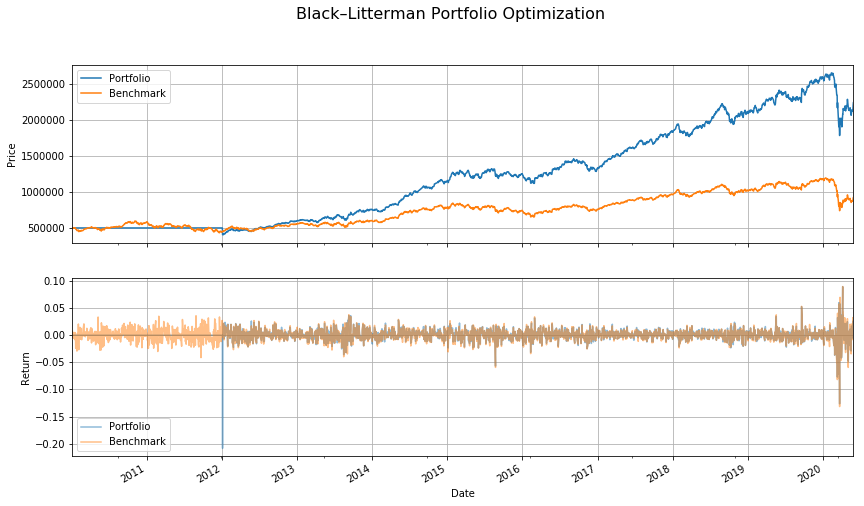

/usr/local/lib/python3.7/site-packages/numpy/core/fromnumeric.py:58: FutureWarning: 
The current behaviour of 'Series.argmin' is deprecated, use 'idxmin'
instead.
The behavior of 'argmin' will be corrected to return the positional
minimum in the future. For now, use 'series.values.argmin' or
'np.argmin(np.array(values))' to get the position of the minimum
row.
  return bound(*args, **kwds)


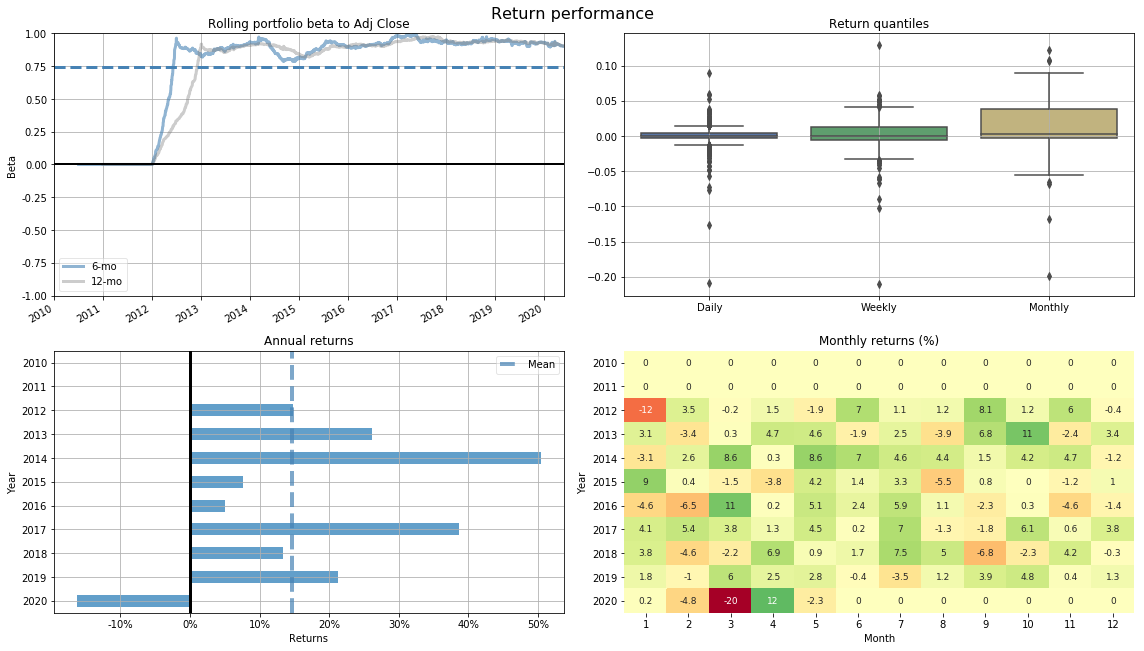

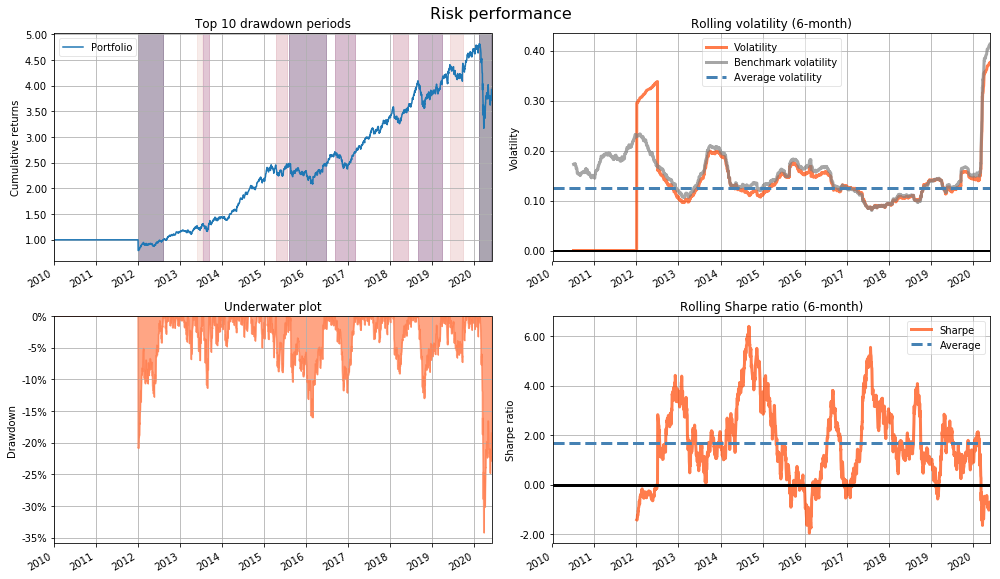

In [21]:
# Plot result
pyfoliozer = results[0].analyzers.getbyname('pyfolio')
returns, positions, transactions, gross_lev = pyfoliozer.get_pf_items()
returns.name = 'Strategy'

plot_performance(
    returns, 
    benchmark_prices, 
    plot_stats=True,
    startcash=startcash,
    log_returns=True,
    save_dir=None
)